In [33]:
import numpy as np
import scipy as sp
import time, sys
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve

mu1,mu2=np.meshgrid(np.linspace(-1,-0.01,12),np.linspace(-1,-0.01,12),indexing='ij')
mu1=mu1.flatten()
mu2=mu2.flatten()
no_para=np.size(mu1,axis=0)

N=70
Ns=(N-1)**2
Nt=50
h=1/N
k=2/Nt
x1,x2=np.meshgrid(np.linspace(0,1,N+1)[1:-1],np.linspace(0,1,N+1)[1:-1],indexing='ij') # only free degrees of freedom
x1=x1.flatten()
x2=x2.flatten()
t=np.linspace(0,2,Nt+1)

e=np.ones(N-1)
A1D=1/h**2*sp.sparse.spdiags(np.vstack((e,-2*e,e)),[-1,0,1],N-1,N-1,format='csc')
A2D=sp.sparse.kron(A1D,sp.sparse.eye(N-1,format='csc'),format='csc')+sp.sparse.kron(sp.sparse.eye(N-1,format='csc'),A1D,format='csc')
I=sp.sparse.eye(Ns,format='csc')

# High-fidelity
U=np.zeros((Ns,no_para*Nt))
FOM_t_start=time.time()
for p in range(no_para):
    A=A2D-sp.sparse.diags(1/np.sqrt((x1-mu1[p])**2+(x2-mu2[p])**2),format='csc')
    f=np.matmul((1/np.sqrt((x1-mu1[p])**2+(x2-mu2[p])**2).reshape(-1,1)),(np.sin(2*np.pi*t).reshape(1,-1)))
    #f=(1/np.sqrt((x1-mu1[p])**2+(x2-mu2[p])**2).reshape(-1,1))@(np.sin(2*np.pi*t).reshape(1,-1))
    u=np.zeros((Ns,Nt+1))
    for n in range(Nt):
        u[:,n+1]=spsolve(I-k*A,u[:,n]+k*f[:,n+1])      
    U[:,np.arange(p*Nt,(p+1)*Nt)]=u[:,1:]
FOM_t_elapsed=time.time()-FOM_t_start
    
# POD of solution snapshot
W,S,VT=np.linalg.svd(U)

# Generate ROM basis
ns=20
PHIs=W[:,:ns]
PHIsT=PHIs.T

# construct Djk
nt=7
D=np.zeros((ns,nt*Nt))
for i in range(ns):
    Ri=VT[i,:]
    Ri=Ri.reshape(-1,no_para,order='F')
    Wi,Si,ViT=np.linalg.svd(Ri)
    PHIti=Wi[:,:nt]
    for j in range(nt):
        D[i,Nt*j:Nt*(j+1)]=PHIti[:,j]
        
# construct PHIst
PHIst=np.zeros((Ns*Nt,ns*nt))
for i in range(Nt):
    for j in range(nt):
        PHIstij=np.zeros((Ns,ns))
        Dij=sp.sparse.diags(D[:,j*Nt+i],format='csc')
        PHIst[Ns*i:Ns*(i+1),ns*j:ns*(j+1)]=PHIs@Dij  
PHIstT=PHIst.T

# Run Space-Time ROM for arbitrary parameter
mu=[-0.5,-0.5] # set parameter mu
A=A2D-sp.sparse.diags(1/np.sqrt((x1-mu[0])**2+(x2-mu[1])**2),format='csc')
f=(1/np.sqrt((x1-mu[0])**2+(x2-mu[1])**2).reshape(-1,1))@(np.sin(2*np.pi*t).reshape(1,-1))
# construct Ast and fst
As=PHIsT@A@PHIs
fs=PHIsT@f
Ast=np.zeros((ns*nt,ns*nt))
for i in range(nt):
    for j in range(nt):
        Astij=np.zeros((ns,ns))
        for kk in range(Nt):
            Dik=sp.sparse.diags(D[:,i*Nt+kk],format='csc')
            Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
            Astij+=Dik@Djk-k*Dik@As@Djk
        for kk in range(Nt-1):
            Dik_next=sp.sparse.diags(D[:,i*Nt+kk+1],format='csc')
            Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
            Astij-=Dik_next@Djk   
        Ast[ns*i:ns*(i+1),ns*j:ns*(j+1)]=Astij  
fst=np.zeros(ns*nt)
for j in range(nt):
    for kk in range(Nt):
        Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
        fst[ns*j:ns*(j+1)]+=k*Djk@fs[:,kk+1]
        
# Space-Time ROM
ROM_t_start=time.time()
UstROM=PHIst@np.linalg.solve(Ast,fst)
ROM_t_elapsed=time.time()-ROM_t_start

# Run HF model to check error when a parameter set is arbitary
mu=[-0.5,-0.5] # set parameter mu
A=A2D-sp.sparse.diags(1/np.sqrt((x1-mu[0])**2+(x2-mu[1])**2),format='csc')
f=(1/np.sqrt((x1-mu[0])**2+(x2-mu[1])**2).reshape(-1,1))@(np.sin(2*np.pi*t).reshape(1,-1))
HF_t_start=time.time()
u=np.zeros((Ns,Nt+1))
for n in range(Nt):
    u[:,n+1]=spsolve(I-k*A,u[:,n]+k*f[:,n+1])
UstHF=u[:,1:].flatten(order='F')
HF_t_elapsed=time.time()-HF_t_start

# Print results
print('max difference',np.max(UstHF-UstROM),'min difference',np.min(UstHF-UstROM))
print('relative error(%)',np.linalg.norm(UstROM-UstHF)/np.linalg.norm(UstHF)*100)
print('speed-up',HF_t_elapsed/ROM_t_elapsed)
print('High Fidelity Model', HF_t_elapsed)
print('ROM Model', ROM_t_elapsed)
print('training time', FOM_t_elapsed)

max difference 4.447610722308967e-07 min difference -4.129098965946834e-07
relative error(%) 0.00023110232853934337
speed-up 60.00165218015947
High Fidelity Model 0.5974409580230713
ROM Model 0.009957075119018555
training time 106.72352695465088


In [77]:
#find residual
print(f.shape)
#U_ROM = np.reshape(UstHF,(Ns,Nt),order="F") #UstHF.reshape(Ns,Nt)
U_ROM = np.reshape(UstROM,(Ns,Nt),order="F")
U_ROMpIC = np.zeros((Ns,Nt+1))
U_ROMpIC[:,1:] = U_ROM
resid=np.zeros((Ns,Nt))
for n in range(Nt):
  resid[:,n]=(I-k*A)*U_ROMpIC[:,n+1]-(U_ROMpIC[:,n]+k*f[:,n+1])
resid_st = resid.flatten(order="F")
print(np.linalg.norm(resid_st))


(4761, 51)
0.0007525702754141288


In [46]:
ee = np.ones(Nt-1)
lower_diag = sp.sparse.spdiags(np.vstack((1*ee,0*ee,0*ee)),[-1,0,1],Nt,Nt,format='csc') 
Abig_st=sp.sparse.kron(sp.sparse.eye(Nt,format='csc'),(I-k*A),format='csc') + \
       sp.sparse.kron(lower_diag,-I,format='csc') 
residual = Abig_st@UstROM-f[:,1:].flatten(order='F')
residual_exact = Abig_st@UstHF-f[:,1:].flatten(order='F')
delta_residual = residual-residual_exact
normalized_residual = residual/np.linalg.norm(residual)
residualnorm = np.linalg.norm(residual)

print(residualnorm)

245.7695115000438


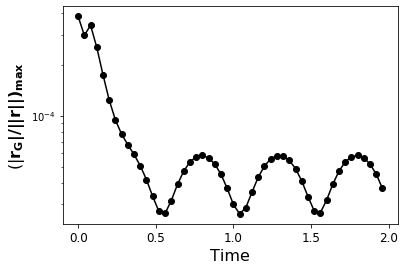

4.7593309398643665e-05


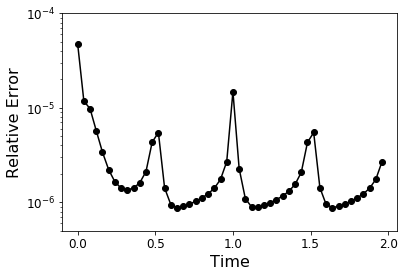

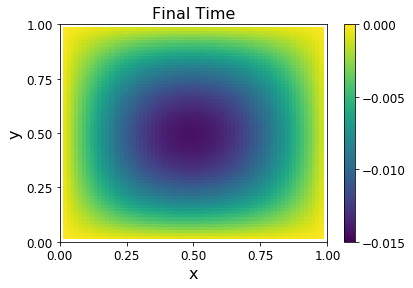

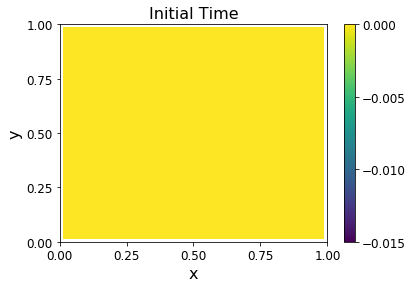

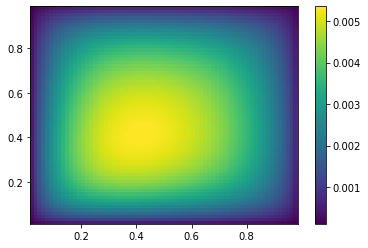

In [79]:
#U_orig = UstHF.reshape(Ns,Nt)
#U_ROM = UstROM.reshape(Ns,Nt)
#print(Ns)
#print(Nt)
#index = 10
#plt.plot(U_orig[:,index])
#plt.plot(U_ROM[:,index])
import os
save_figures = False
directory = 'plots1'
#if directory doesn't exist, create it
if not os.path.exists(os.path.join(os.getcwd(), directory)):
    os.mkdir(os.path.join(os.getcwd(), directory))

U_orig = np.reshape(UstHF,(Ns,Nt),order="F") #UstHF.reshape(Ns,Nt)
U_ROM = np.reshape(UstROM,(Ns,Nt),order="F")
u_orig = u[:,1:]
xx,yy=np.meshgrid(np.linspace(0,1,N+1)[1:-1],np.linspace(0,1,N+1)[1:-1],indexing='ij') # only free degrees of freedom

#residual
norm_residual_inTime = np.zeros(Nt)
for i in range(Nt):
    #residual_t = residual[i*(N-1)*(N-1):i*(N-1)*(N-1)+(N-1)*(N-1)]
    residual_t = resid[:,i]
    norm_residual_inTime[i] =  np.linalg.norm(residual_t) #np.max(np.abs(residual_t))
plt.figure()
time = np.arange(Nt)*k
plt.semilogy(time,norm_residual_inTime,'k-o')
plt.xlabel(r'Time',fontsize=16)
plt.ylabel(r'$(|\bf{r_G}|/||\bf{r}||) _{max}$',fontsize=16)
plt.xticks([0,0.5,1.0,1.5,2.0],fontsize=12)
#plt.yticks([1e-7,1e-5,1e-3],fontsize=12)
#plt.ylim([1e-2,9e-1])
np.savetxt(os.path.join(os.getcwd(), directory,"residual_file.txt"),norm_residual_inTime)
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "galerkin_residual_vs_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()

#Relative error
relative_error = np.zeros(Nt)
for i in range(Nt):
    relative_error[i] = np.linalg.norm(U_ROM[:,i]-U_orig[:,i])/np.linalg.norm(U_orig[:,i]) 
    #relative_error[i] = np.max(np.abs(U_ROM[:,i]-U_orig[:,i]))/np.linalg.norm(U_orig[:,i])
    
plt.figure()
time = np.arange(Nt)*k
plt.semilogy(time,relative_error,'k-o')
plt.xlabel(r'Time',fontsize=16)
plt.ylabel(r'Relative Error',fontsize=16)
plt.xticks([0,0.5,1.0,1.5,2.0],fontsize=12)
plt.yticks([1e-6,1e-5,1e-4],fontsize=12)
plt.ylim([5e-7,1e-4])
np.savetxt(os.path.join(os.getcwd(), directory,"relative_error_file.txt"),relative_error)
print(relative_error[0])
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "galerkin_error_vs_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()

index = 49
plt.figure()
plt.pcolormesh(xx,yy,U_ROM[:,index].reshape(N-1,N-1),linewidth=0,rasterized=True)
#plt.colorbar()
plt.clim(0, -0.015)
cbar = plt.colorbar(ticks=[0,-0.005,-0.01,-0.015])#, label=['0','-0.005','-0.010','-0.015'])
cbar.ax.tick_params(labelsize=12) 
plt.xlabel(r'x',fontsize=16)
plt.ylabel(r'y',fontsize=16)
plt.title(r'Final Time',fontsize=16)
plt.xticks([0,0.25,0.50,0.75,1.0],fontsize=12)
plt.yticks([0,0.25,0.50,0.75,1.0],fontsize=12)
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "galerkin_pcolor_final_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()
        

index = 0
plt.figure()
plt.pcolormesh(xx,yy,U_ROM[:,index].reshape(N-1,N-1),linewidth=0,rasterized=True)
#plt.colorbar()
plt.clim(0, -0.015)
cbar = plt.colorbar(ticks=[0,-0.005,-0.01,-0.015])#, label=['0','-0.005','-0.010','-0.015'])
cbar.ax.tick_params(labelsize=12) 
plt.xlabel(r'x',fontsize=16)
plt.ylabel(r'y',fontsize=16)
plt.title(r'Initial Time',fontsize=16)
plt.xticks([0,0.25,0.50,0.75,1.0],fontsize=12)
plt.yticks([0,0.25,0.50,0.75,1.0],fontsize=12)
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "galerkin_pcolor_initial_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()

plt.figure()
plt.pcolormesh(xx,yy,U_orig[:,index].reshape(N-1,N-1))
plt.colorbar()
plt.show()
